In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station= Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

my_trp_get_temps = calc_temps('2017-07-24', '2017-08-08')
tmin, tavg, tmax =  my_trp_get_temps[0][0], my_trp_get_temps[0][1], my_trp_get_temps[0][2]


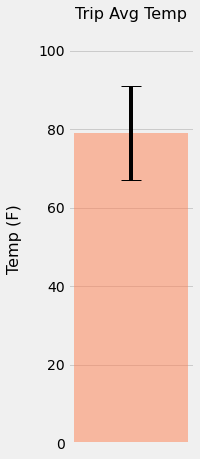

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
y_err = tmax-tmin
fig, ax = plt.subplots(figsize=(2,7))
ax.bar(x=0, height=tavg, yerr=y_err, width=0.5, color="coral", alpha=0.5, capsize=10, ecolor="black")
plt.ylim(0,tmax+20)
plt.xticks([])
plt.title('Trip Avg Temp',fontsize=16, pad=16)
plt.ylabel('Temp (F)',fontsize=16,labelpad=16)
plt.show()


### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
my_trip_start_date = '2017-07-24'
my_trip_end_date   = '2017-08-08'

# get_trip_tot_rain_fall_per_station = session.query(Measurement.station,func.sum(Measurement.prcp)).\
#     filter(Measurement.date >= my_trip_start_date).\
#     filter(Measurement.date <= my_trip_end_date).\
#     group_by(Measurement.station).all()

get_tot_rain_fall_for_trip_per_station = session.query(Station.station,Station.name,\
    Station.latitude, Station.longitude, Station.elevation,
    func.sum(Measurement.prcp).label('Total_RainFall')).\
    filter(Measurement.date >= my_trip_start_date).\
    filter(Measurement.date <= my_trip_end_date).\
    filter(Measurement.station == Station.station).\
    group_by(Station.station,Station.name,\
    Station.latitude, Station.longitude, Station.elevation).\
    order_by(func.sum(Measurement.prcp).desc()).all()  

# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# display
pd.DataFrame(get_tot_rain_fall_for_trip_per_station, columns=['station', 'name', 'latitude', 'longitude', \
    'elevation', 'Total_RainFall'])

,station,name,latitude,longitude,elevation,Total_RainFall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,3.14
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.81
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.23
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.86
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.09
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.05
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.01


In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [15]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
my_trip_start_date = '2017-07-24'
my_trip_end_date   = '2017-08-08'

my_trip_start_date   = dt.datetime.strptime(my_trip_start_date, '%Y-%m-%d').date()
my_trip_end_date = dt.datetime.strptime(my_trip_end_date, '%Y-%m-%d').date()

trip_length =  my_trip_end_date - my_trip_start_date    
trip_length_in_days = trip_length.days


# Use the start and end date to create a range of dates

trip_dates = [dt.datetime.strftime(my_trip_start_date,'%Y-%m-%d')]
normals = [(tmin,tavg,tmax)]
my_trip_next_date = my_trip_start_date
for i in range(trip_length_in_days):
    
    #Save a list of strings in the format %Y-%m-%d
    trip_dates.append(dt.datetime.strftime((my_trip_next_date + dt.timedelta(days=1)), '%Y-%m-%d'))

    # Strip off the year
    stripped_date = dt.datetime.strftime((my_trip_next_date + dt.timedelta(days=1)), '%m-%d')
    # Use the `daily_normals` function to calculate the normals for each date string 
    # and append the results to a list called `normals`.
    tmin,tavg,tmax = np.ravel(daily_normals(stripped_date))
    normals.append((tmin,tavg,tmax))

    my_trip_next_date = my_trip_next_date + dt.timedelta(days=1)


In [16]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df = pd.DataFrame(normals, columns=['Tmin', 'Tavg', 'Tmax'], index=trip_dates)
trip_df

,Tmin,Tavg,Tmax
2017-07-24,72.0,79.047619,84.0
2017-07-25,67.0,76.890909,84.0
2017-07-26,71.0,76.442308,86.0
2017-07-27,68.0,76.581818,83.0
2017-07-28,69.0,76.464286,82.0
2017-07-29,69.0,76.470588,83.0
2017-07-30,69.0,77.351852,84.0
2017-07-31,72.0,77.035714,83.0
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0


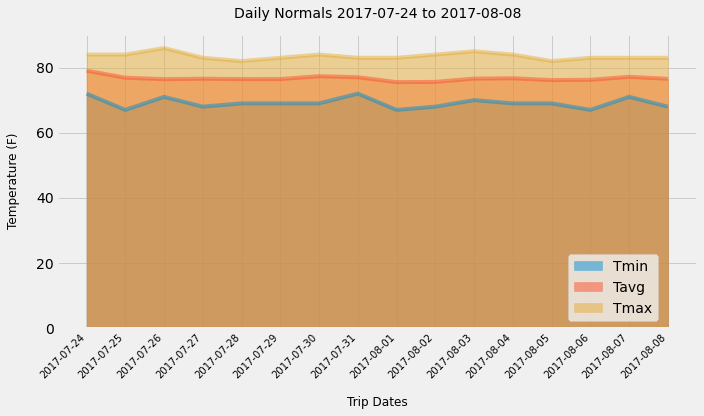

In [17]:
# Plot the daily normals as an area plot with `stacked=False`

fig, ax = plt.subplots(figsize=(10,6))
trip_df.plot.area(ax=ax,stacked=False)
plt.xticks(range(len(trip_dates)), trip_dates, rotation=45, ha='right', fontsize=10)
# plt.xlim(0,len(trip_dates)-1)
# plt.ylim(0,trip_df['Tmax'].max()+10)
plt.xlabel("Trip Dates", labelpad=16, fontsize=12)
plt.ylabel("Temperature (F)", labelpad=16, fontsize=12)
plt.title(f"Daily Normals {trip_df.index.min()} to {trip_df.index.max()}", pad=16, fontsize=14)
plt.legend(loc="lower right" , bbox_to_anchor=(0.95, 0))
plt.tight_layout()
plt.show()

## Close Session

In [18]:
session.close()